In [3]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.stats import skew
import Scope_funcs as sf


imports work
imports work


In [4]:
hit_data_scope_1081 = sf.DUT_TELE_merge(1081)

In [5]:
scope_data_1088=sf.DUT_TELE_merge(1088)

In [3]:
# hit_data_1093 = rf.get_ROOT_data_zip_RECO(1093)
# hit_data_1088 = rf.get_ROOT_data_zip_RECO(1088)
hit_data_scope_1093 = sf.DUT_TELE_merge(1093)

In [3]:
# gal_scope_1081 = sf.gal_scope_merge(1081)

DataFrames constructed.
DataFrames grouped by TLU/triggerid
DataFrames merged
collected garbage


In [6]:
hit_data_1081 = rf.get_ROOT_data_zip_RECO(1081)

1081 RECONSTRUCTED finished


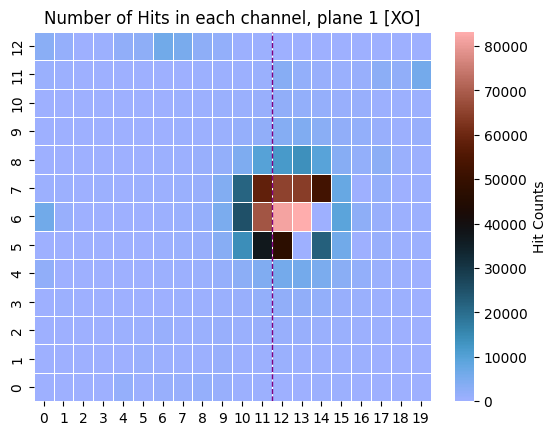

In [7]:
rf.hits_amount_colormap_single_plane(hit_data_1081,1)

<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

PAD RECONSTRUCTION

In [22]:
# add the reconstructed data of the dead pad to the hits data
def add_reconstruct_data_single_dead_pad(data, plane, pad, scope_data = True, only_reco_data = False):

    if scope_data:
        hit_data = data.hits

    # get the array of the reconstructed data
    reco_pad = rf.pads_reconstruct(hit_data, plane, pad)

    # turn empty data in the reconstructed results to zeros
    reco_amp = ak.fill_none(ak.firsts(reco_pad), 0.0)

    # zip the reconstructed data to plane and ch of dead pad
    reco_pad_plane_ch = ak.zip(
        {
            "plane": ak.full_like(reco_amp, plane, dtype="int32"),
            "ch":    ak.full_like(reco_amp, pad, dtype="int32"),
            "amp":   reco_amp,
        })

    # turn the reconstructed data into subarrays per event
    reco1 = ak.unflatten(reco_pad_plane_ch, 1)

    # turn all zeros to empty spaces
    keep = reco_amp != 0
    reco_to_add = ak.fill_none(ak.mask(reco1, keep), [])

    if only_reco_data:
        return reco_to_add

    # combine with original data
    hits_with_reco_pad = ak.concatenate([hit_data, reco_to_add], axis=1)

    data_with_reco_pad = ak.with_field(data, hits_with_reco_pad, "hits")

    return data_with_reco_pad

# reco_146_1093 = add_reconstruct_data_single_dead_pad(hit_data_scope_1093, 4, 146)

In [23]:
# reconstruct the dead channels around the shower in a run - radius of reco dtermines the distance from the center of the shower to be reconstructed
def reconstruct_data_all_dead_pads2(data, radius, path_to_diagnostics, number_of_planes = 8):

# find the center of the shower

    # single hit in the first plane
    first_plane1 = data.hits[data.hits.plane == 0]
    first_plane = first_plane1[ak.num(first_plane1) == 1]

    # ch activated in the first plane
    first_plane_ch = first_plane.ch

    # define center of the shower as the most activated pad in the first plane 
    counted_channels, counts = np.unique(ak.flatten(first_plane_ch), axis=0, return_counts=True)
    imax = np.argmax(counts)
    central_pad = counted_channels[imax]
    print("shower center:", central_pad)   
    



# get the dead channels list

    # list of all dead channels
    all_dead_channels = rf.channels_diagnostics(path_to_diagnostics, number_of_planes)
    print("amount of dead channels:", len(all_dead_channels))
    
    # get the pads in the wanted radius
    base = list(range(central_pad - radius, central_pad + radius +1))
    pads = [x + 20*i for i in range(-radius, radius+1) for x in base]
    
    # get the dead channels only from the wanted radius
    radius_mask = np.isin(all_dead_channels.channel_ID, pads)
    dead_channels_in_radius1 = all_dead_channels[radius_mask] 

    # delete dead channels starting at the first plane as we cant average for them
    dead_channels_in_radius = dead_channels_in_radius1[dead_channels_in_radius1.plane_ID > 0]


# add the reconstructed data
    reco_data_list = []
    counter = len(dead_channels_in_radius)
    for channel in dead_channels_in_radius:
        
        reco_data_to_add = add_reconstruct_data_single_dead_pad(data, channel.plane_ID, channel.channel_ID, only_reco_data=True)

        reco_data_list.append(reco_data_to_add)

        print(channel)
        counter -= 1
        print(counter, "channels left")
    
     # combine all channels' reco hits: N * (sum hits) * record
    reco_all = ak.concatenate(reco_data_list, axis=1)

    # append ONCE
    hits2 = ak.concatenate([data.hits, reco_all], axis=1)

    # put back into full data record
    data2 = ak.with_field(data, hits2, "hits")



    # counter = len(dead_channels_in_radius)
    # for channel in dead_channels_in_radius:
    #     data = add_reconstruct_data_single_dead_pad(data, channel.plane_ID, channel.channel_ID)
    #     print(channel)
    #     counter -= 1
    #     print(counter, "channels left")
    
    return data2

    # connect with the originial data
path = "TB_FIRE\TB_reco\TB_FIRE_1093_raw_reco_diagnostics.root"


# b = reconstruct_data_all_dead_pads2(hit_data_scope_1093, 2, path)


<>:74: SyntaxWarning: invalid escape sequence '\T'
<>:74: SyntaxWarning: invalid escape sequence '\T'
C:\Users\bents\AppData\Local\Temp\ipykernel_11520\4031925208.py:74: SyntaxWarning: invalid escape sequence '\T'
  path = "TB_FIRE\TB_reco\TB_FIRE_1093_raw_reco_diagnostics.root"


In [4]:
path = "TB_FIRE\TB_reco\TB_FIRE_1093_raw_reco_diagnostics.root"
a = rf.reconstruct_data_all_dead_pads(hit_data_scope_1093, 3, path)
a

<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\bents\AppData\Local\Temp\ipykernel_20832\2337647192.py:1: SyntaxWarning: invalid escape sequence '\T'
  path = "TB_FIRE\TB_reco\TB_FIRE_1093_raw_reco_diagnostics.root"


shower center: 124
we got the data
amount of dead channels: 140
{plane_ID: 2, channel_ID: 61}
17 channels left
{plane_ID: 2, channel_ID: 67}
16 channels left
{plane_ID: 2, channel_ID: 102}
15 channels left
{plane_ID: 2, channel_ID: 144}
14 channels left
{plane_ID: 4, channel_ID: 61}
13 channels left
{plane_ID: 4, channel_ID: 62}
12 channels left
{plane_ID: 4, channel_ID: 63}
11 channels left
{plane_ID: 4, channel_ID: 64}
10 channels left
{plane_ID: 4, channel_ID: 65}
9 channels left
{plane_ID: 4, channel_ID: 66}
8 channels left
{plane_ID: 4, channel_ID: 67}
7 channels left
{plane_ID: 4, channel_ID: 81}
6 channels left
{plane_ID: 4, channel_ID: 121}
5 channels left
{plane_ID: 4, channel_ID: 146}
4 channels left
{plane_ID: 5, channel_ID: 181}
3 channels left
{plane_ID: 5, channel_ID: 183}
2 channels left
{plane_ID: 6, channel_ID: 146}
1 channels left
{plane_ID: 7, channel_ID: 147}
0 channels left


<Array [{tele: [{...}], hits: [...]}, ...] type='440902 * {tele: var * {x: ...'>

<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

GAP 1081

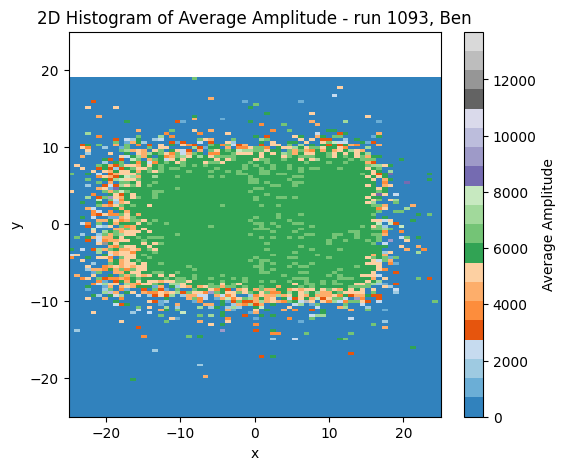

In [6]:
# xy_data = hit_data_scope_1093
xy_data = a


X_ben1 = ak.flatten(xy_data.tele.x)
Y_ben1 = ak.flatten(xy_data.tele.y)

X_ben = -ak.to_numpy(X_ben1)
Y_ben = ak.to_numpy(Y_ben1)

amp_ben1 = ak.sum(xy_data.hits.amp, axis = 1)
amp_ben = ak.to_numpy(amp_ben1)

# Define bins
bins = 300

# Histogram of SUM of amplitudes
sum_amp, xedges, yedges = np.histogram2d(X_ben, Y_ben, bins=bins, weights=amp_ben)

# Histogram of COUNTS
counts, _, _ = np.histogram2d(X_ben, Y_ben, bins=[xedges, yedges])

# Avoid division by zero
avg_amp = np.divide(sum_amp, counts, out=np.zeros_like(sum_amp), where=counts > 0)

# Plot
plt.figure(figsize=(6,5))
plt.pcolormesh(xedges, yedges, avg_amp.T, cmap="tab20c")  
plt.colorbar(label="Average Amplitude")
# plt.xlim(min(X_ben), max(X_ben))
plt.xlim(-25, 25)
# plt.ylim(min(Y_ben), max(Y_ben))
plt.ylim(-25, 25)
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Histogram of Average Amplitude - run 1093, Ben")
plt.show()


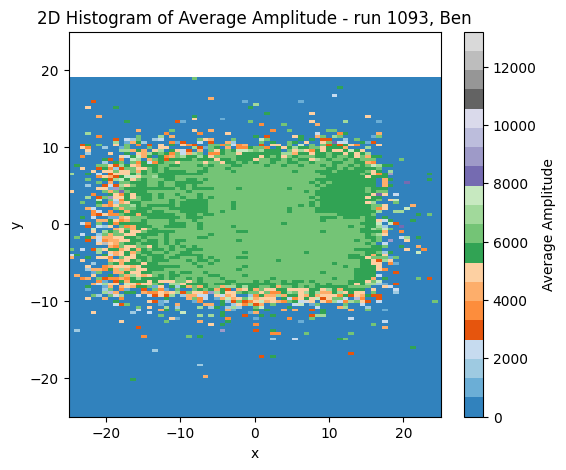

In [4]:
sf.avg_energy_scope_colormap(a, x_borders=25, y_borders=25)

In [ ]:
path = "TB_FIRE\TB_reco\TB_FIRE_1081_raw_reco_diagnostics.root"
hit_data_1081_reco_pads = reconstruct_data_all_dead_pads2(hit_data_scope_1081, 6, path)

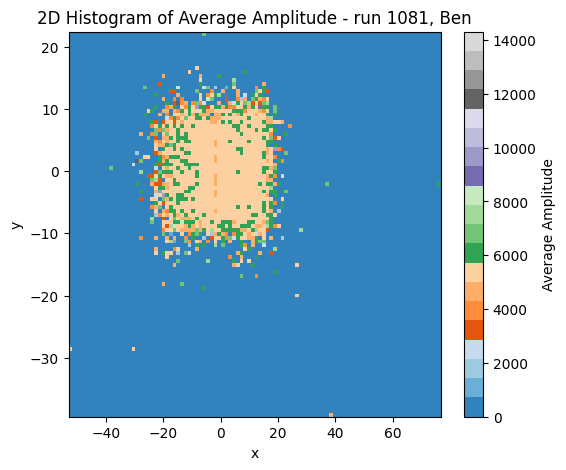

In [15]:
hit_data_scope_1081_filtered = sf.filter_chi2_scope_data(hit_data_scope_1081, 3)

data = hit_data_scope_1081
data = hit_data_1081_reco_pads
# data = hit_data_scope_1081_filtered

X_ben1 = ak.flatten(data.tele.x)
Y_ben1 = ak.flatten(data.tele.y)

X_ben = -ak.to_numpy(X_ben1)
Y_ben = ak.to_numpy(Y_ben1)

amp_ben1 = ak.sum(data.hits.amp, axis = 1)
amp_ben = ak.to_numpy(amp_ben1)

# mask = (X_ben > -10) & (X_ben < 10)
# mask = (amp_ben < 8000)
mask = amp_ben > 0
X_ben_mask = X_ben[mask]
Y_ben_mask = Y_ben[mask]
amp_ben_mask = amp_ben[mask]

# Define bins
bins = 100

# Histogram of SUM of amplitudes
sum_amp, xedges, yedges = np.histogram2d(X_ben_mask, Y_ben_mask, bins=bins, weights=amp_ben_mask)

# Histogram of COUNTS
counts, _, _ = np.histogram2d(X_ben_mask, Y_ben_mask, bins=[xedges, yedges])

# Avoid division by zero
avg_amp = np.divide(sum_amp, counts, out=np.zeros_like(sum_amp), where=counts > 0)


# Plot
plt.figure(figsize=(6,5))
plt.pcolormesh(xedges, yedges, avg_amp.T, cmap="tab20c")  
plt.colorbar(label="Average Amplitude")
plt.xlim(min(X_ben_mask), max(X_ben_mask))
# plt.xlim(-30, 30)
plt.ylim(min(Y_ben_mask), max(Y_ben_mask))
# plt.ylim(-30, 20)
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Histogram of Average Amplitude - run 1081, Ben")
plt.show()


In [75]:
def E_vs_X_scope_gaussian_fit(hit_data, chi2, y_min=-10, y_max=10, x_min=-20, x_max=20, bin_size = 0.4, return_param=False):

    # filter data by chi2
    hit_data_chi2 = sf.filter_chi2_scope_data(hit_data, chi2)
    y_max, y_min

    # take the data from the seletced y range
    data = hit_data_chi2[ak.flatten((hit_data_chi2.tele.y < y_max) & (hit_data_chi2.tele.y > y_min))]
    data = data[ak.num(data.tele) > 0]


    # compute X and E
    X1 = -ak.to_numpy(ak.mean(data.tele.x, axis=1))
    X = bin_size * np.round(X1 / bin_size)
    E = ak.sum(data.hits.amp, axis=1)

    # grouping
    amp, mean, pos = rf.ak_groupby(X, E, round="false")

    # statistics
    amp_avg = ak.mean(amp.data, axis=1)
    amp_std = ak.std(amp.data, axis=1) / np.sqrt(ak.num(amp.data, axis=1) - 1)

    # choose the range of X
    mask = (pos > x_min) & (pos < x_max)

    # convert Awkward → Numpy
    pos_m = ak.to_numpy(pos[mask])
    amp_m = ak.to_numpy(amp_avg[mask])
    err_m = ak.to_numpy(amp_std[mask])

    # Fitting

    #  Gaussian model 
    def gaussian_linear(x, c, m, A, mu, sigma):
        return c + m*x - A * np.exp(-(x - mu)**2 / (2 * sigma**2))

    # initial guesses
    c0 = 6000
    m0 = 0
    A0 = np.min(amp_m)
    # mu0 = pos_m[np.argmin(amp_m)]
    mu0 = 0
    sigma0 = 3
    # sigma0 = (np.max(pos_m) - np.min(pos_m)) / 6

    # fit
    popt, pcov = curve_fit(gaussian_linear, pos_m, amp_m, p0=[c0, m0, A0, mu0, sigma0])

    # fitted values
    c_fit, m_fit, A_fit, mu_fit, sigma_fit = popt
    
    # uncertainties
    perr = np.sqrt(np.diag(pcov))  # 1-sigma uncertainties
    c_err, m_err, A_err, mu_err, sigma_err = perr

    # return the fitting results if needed
    if return_param:
        return popt, perr

    # slope and uncertainty of the fitted function
    theta_fit = np.arctan(m_fit)
    theta_err = m_err / (1.0 + m_fit**2)


    print("Gaussian fit parameters:")
    print(f"c     = {c_fit:.3f}")
    print(f"m     = {m_fit:.3f}")
    print(f"theta     = {np.arctan(m_fit):.3f} Radians")
    print(f"A     = {A_fit:.3f}")
    print(f"mu    = {mu_fit:.3f}")
    print(f"sigma = {sigma_fit:.3f}")

    fig, ax = plt.subplots()
    ax.errorbar(pos_m, amp_m, yerr=err_m, fmt='.', capsize=4, label="data")

    # make a smooth fitted function
    x_fit = np.linspace(np.min(pos_m), np.max(pos_m), 500)
    y_fit = gaussian_linear(x_fit, *popt)
    ax.plot(x_fit, y_fit, 'r-', label="Gaussian fit", zorder=10)

    # build textbox string
    textstr = "\n".join([
        r"$c = %.3f \pm %.3f$" % (c_fit, c_err),
        r"$m = %.3f \pm %.3f$" % (m_fit, m_err),
        r"$\theta = %.3f \pm %.3f$ rad" % (theta_fit, theta_err),
        r"$A = %.3f \pm %.3f$" % (A_fit, A_err),
        r"$\mu = %.3f \pm %.3f$" % (mu_fit, mu_err),
        r"$\sigma = %.3f \pm %.3f$" % (sigma_fit, sigma_err),
    ])

    # add textbox (axes coordinates: 0..1)
    ax.text(
        0.65, 0.98, textstr,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="pink", alpha=0.8, edgecolor="0.5")
    )

    ax.grid(True)
    ax.set_xlabel("X Scope")
    ax.set_ylabel("Energy [ADC] (avg ± std)")
    # ax.set_title(r"Average Energy vs Scope X Position \n Fit to $y = m \cdot x + c - A\cdot e^{\frac{-(x - \mu)^2}{(2 \sigma^2)}}$")
    ax.set_title("Average Energy vs Scope X Position\n"
             r"Fit to: $y = m \cdot x + c - A\cdot exp(\frac{-(x - \mu)^2}{2 \sigma^2})$")

    ax.legend(loc="upper left")
    # leg = ax.legend(loc="upper right", title=textstr, frameon=True)
    plt.show()


Gaussian fit parameters:
c     = 5777.012
m     = -4.042
theta     = -1.328 Radians
A     = 2315.802
mu    = -2.223
sigma = 0.999


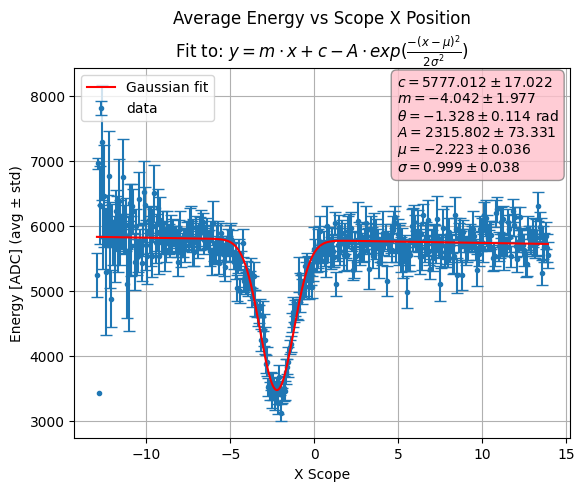

In [76]:
E_vs_X_scope_gaussian_fit(scope_data_1088, 1, 4, 5, -13, 14, bin_size=0.07)

In [ ]:
def plot_gap_vs_y(scope_data, y_range=10, y_bins=1, chi2=1):

    # lists for the plotting
    c_list = []
    A_list = []
    mu_list = []
    sigma_list = []
    y_list = []

    for i in np.arange(-y_range, y_range, y_bins):

        # get the gaussian parameters for each y
        print(i)
        c,m,A,mu,sigma = E_vs_X_scope_gaussian_fit(scope_data, chi2, i, i+y_bins, -13, 14, bin_size=0.04, return_param=True)
        
        y = i + y_bins/2
        y_list.append(y)

        # save the data
        c_list.append(c)
        A_list.append(A)
        mu_list.append(mu)
        sigma_list.append(sigma)

    # plot the parameters

    # different graphs
    fig, axs = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=True)

    linewdith = 1
    markersize = 3
    axs[0, 0].plot(y_list, c_list, "-o", linewidth=linewdith, markersize=markersize)
    axs[0, 0].set_title("Average Energy Outside the Gap")
    axs[0,0].set_ylabel("Energy Count [ADC]")

    axs[0, 1].plot(y_list, A_list, "-o", linewidth=linewdith, markersize=markersize)
    axs[0, 1].set_title("Energy Inside the Gap (Gaussian Depth)")
    axs[0,1].set_ylabel("Energy Count Inside the Gap [ADC]")

    axs[1, 0].plot(y_list, mu_list, "-o", linewidth=linewdith, markersize=markersize)
    axs[1, 0].set_title("Gap Position on the scope (mu)")
    axs[1,0].set_ylabel("Gap Position [mm]")

    axs[1, 1].plot(y_list, sigma_list, "-o", linewidth=linewdith, markersize=markersize)
    axs[1, 1].set_title("Gap width (sigma)")
    axs[1,1].set_ylabel("sigma [mm]")

    for ax in axs.ravel():
        ax.grid(True, alpha=0.3)
        ax.set_xlabel("y")
        ax.tick_params(axis="x", labelleft=True)


    # # all on the same one
    # linewdith = 1
    # markersize = 3
    # plt.plot(y_list, c_list, "-o", linewidth=linewdith, markersize=markersize, label="C")
    
    # plt.plot(y_list, A_list,  "-o", linewidth=linewdith, markersize=markersize, label="A")
    
    # plt.plot(y_list, mu_list, "-o", linewidth=linewdith, markersize=markersize, label="mu")
    
    # plt.plot(y_list, sigma_list, "-o", linewidth=linewdith, markersize=markersize, label="sigma")
    
    # plt.grid()
    # plt.legend

    # fig.tight_layout()
    plt.show()


In [137]:
# with uncertainties
def plot_gap_vs_y(scope_data, y_range=10, y_bins=1, chi2=1):

    # lists for the plotting
    c_list = []
    c_err_list = []
    A_list = []
    A_err_list = []
    mu_list = []
    mu_err_list = []
    sigma_list = []
    sigma_err_list = []
    y_list = []

    for i in np.arange(-y_range, y_range, y_bins):

        # get the gaussian parameters for each y
        popt, perr = E_vs_X_scope_gaussian_fit(scope_data, chi2, i, i+y_bins, -13, 14, bin_size=0.04, return_param=True)
        c, m, A, mu, sigma = popt
        c_err, m_err, A_err, mu_err, sigma_err = perr
        
        y = i + y_bins/2
        y_list.append(y)

        # save the data
        c_list.append(c)
        c_err_list.append(c_err)
        A_list.append(A)
        A_err_list.append(A_err)
        mu_list.append(mu)
        mu_err_list.append(mu_err)
        sigma_list.append(sigma)
        sigma_err_list.append(sigma_err)


    # plot the parameters
    fig, axs = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=True)

    linewdith = 1
    markersize = 3

    # plot C
    axs[0,0].errorbar(y_list, c_list, yerr=c_err_list, fmt='.', capsize=4, label="data")
    axs[0, 0].set_title("Average Energy Outside the Gap (c)")
    axs[0,0].set_ylabel("Energy Count [ADC]")

    # plot A
    axs[0,1].errorbar(y_list, A_list, yerr=A_err_list, fmt='.', color="red", capsize=4, label="data")
    axs[0, 1].set_title("Energy Inside the Gap (Gaussian Depth - A)")
    axs[0,1].set_ylabel("Energy Count Inside the Gap [ADC]")

    # plot gaussian mean (mu)
    axs[1,0].errorbar(y_list, mu_list, yerr=mu_err_list, fmt='.', color="purple", capsize=4, label="data")
    axs[1, 0].set_title("Gap Position on the scope (mu)")
    axs[1,0].set_ylabel("Gap Position [mm]")

    # plot gaussian width (sigma)
    axs[1,1].errorbar(y_list, sigma_list, yerr=sigma_err_list, fmt='.', color="green", capsize=4, label="data")
    axs[1, 1].set_title("Gap width (sigma)")
    axs[1,1].set_ylabel("sigma [mm]")

    for ax in axs.ravel():
        ax.grid(True, alpha=0.3)
        ax.set_xlabel("y")
        ax.tick_params(axis="x", labelleft=True)

    plt.show()


In [87]:
path = "TB_FIRE\TB_reco\TB_FIRE_1088_raw_reco_diagnostics.root"
scope_data_1088_corrected = rf.reconstruct_data_all_dead_pads(scope_data_1088, 5, path)

<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\bents\AppData\Local\Temp\ipykernel_26236\2696076564.py:1: SyntaxWarning: invalid escape sequence '\T'
  path = "TB_FIRE\TB_reco\TB_FIRE_1088_raw_reco_diagnostics.root"


shower center: 112
we got the data
amount of dead channels: 140
{plane_ID: 1, channel_ID: 77}
48 channels left
{plane_ID: 1, channel_ID: 133}
47 channels left
{plane_ID: 2, channel_ID: 32}
46 channels left
{plane_ID: 2, channel_ID: 50}
45 channels left
{plane_ID: 2, channel_ID: 54}
44 channels left
{plane_ID: 2, channel_ID: 67}
43 channels left
{plane_ID: 2, channel_ID: 77}
42 channels left
{plane_ID: 2, channel_ID: 148}
41 channels left
{plane_ID: 2, channel_ID: 172}
40 channels left
{plane_ID: 2, channel_ID: 173}
39 channels left
{plane_ID: 2, channel_ID: 174}
38 channels left
{plane_ID: 2, channel_ID: 175}
37 channels left
{plane_ID: 2, channel_ID: 176}
36 channels left
{plane_ID: 2, channel_ID: 177}
35 channels left
{plane_ID: 2, channel_ID: 192}
34 channels left
{plane_ID: 2, channel_ID: 193}
33 channels left
{plane_ID: 2, channel_ID: 195}
32 channels left
{plane_ID: 2, channel_ID: 212}
31 channels left
{plane_ID: 2, channel_ID: 213}
30 channels left
{plane_ID: 2, channel_ID: 217}

C:\Users\bents\AppData\Local\Temp\ipykernel_26236\2646746306.py:48: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian_linear, pos_m, amp_m, p0=[c0, m0, A0, mu0, sigma0])


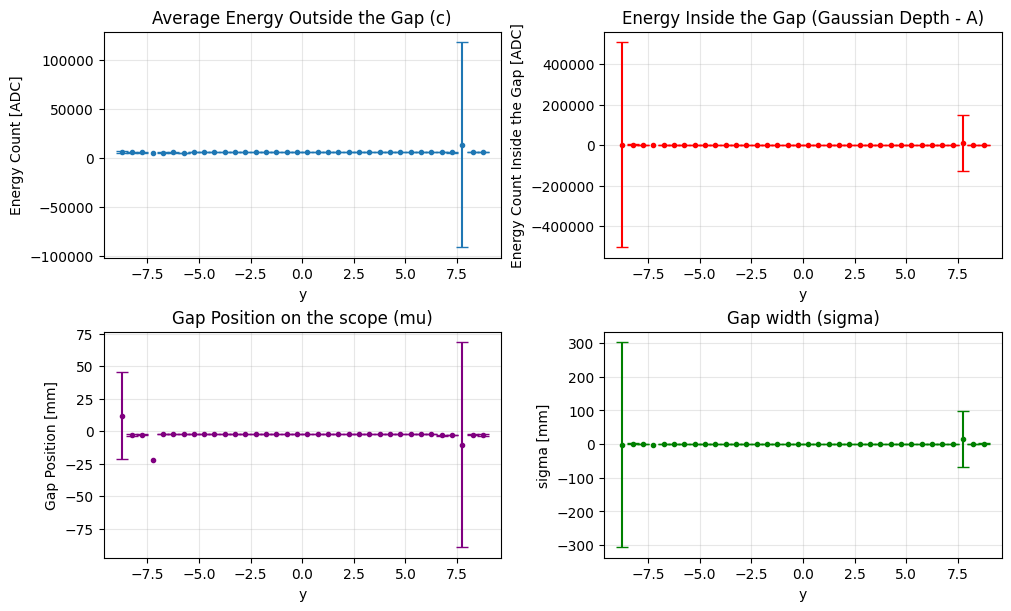

In [141]:
plot_gap_vs_y(scope_data_1088, y_range = 9, y_bins=0.5)

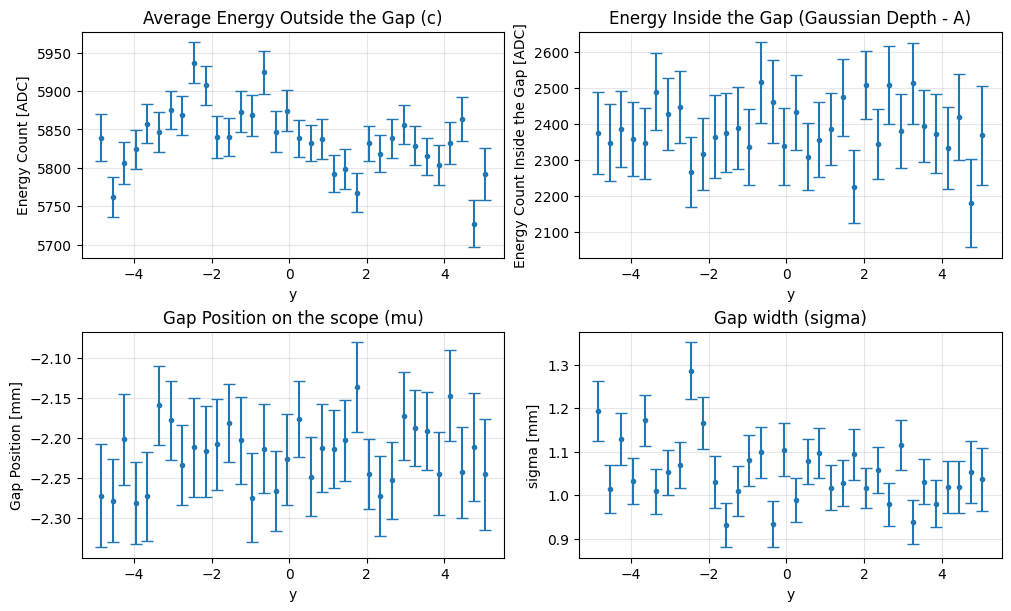

In [99]:
plot_gap_vs_y(scope_data_1088_corrected, y_range = 5, y_bins=0.3)

In [40]:
arr = np.array([-0.3, -0.1, 0, 0.07,0.08, 0.1, 0.2])
bin_size = 0.2
# offset = bin_size 
offset = 0 

binned = bin_size * np.round(arr / bin_size)
binned

array([-0.2, -0. ,  0. ,  0. ,  0. ,  0. ,  0.2])

In [ ]:

tlu_ben = ak.firsts(hit_data_scope_1081_tlu.hits.TLU, axis = 1) 
tlu_gal = ak.firsts(gal_scope_1081.TLU)
gal_in_ben_mask = np.isin(tlu_gal,tlu_ben)
tlu_gal_in_ben = tlu_gal[~gal_in_ben_mask]

In [17]:
gal_ben_1081_scope = gal_scope_1081[~gal_in_ben_mask]

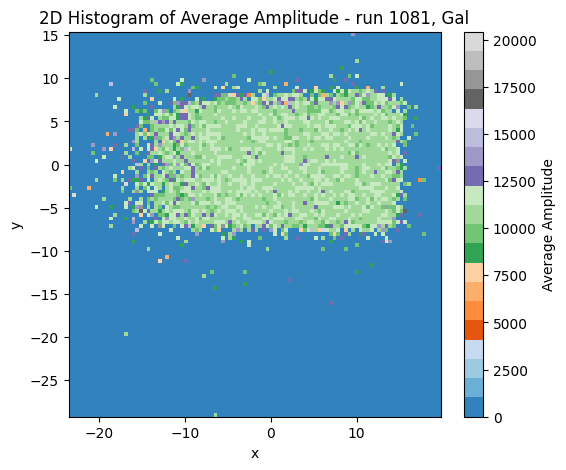

In [8]:
gal_ben_1081_scope = gal_scope_1081[~gal_in_ben_mask]
X_gal1 = ak.mean(gal_ben_1081_scope.x_dut, axis=1)
Y_gal1 = ak.mean(gal_ben_1081_scope.y_dut, axis=1)

X_gal = -ak.to_numpy(X_gal1)
Y_gal = ak.to_numpy(Y_gal1)

amp_gal1 = ak.sum(gal_ben_1081_scope.Amplitudes, axis=1)
amp_gal = ak.to_numpy(amp_gal1)

# Define bins
bins = 100

# Histogram of SUM of amplitudes
sum_amp, xedges, yedges = np.histogram2d(X_gal, Y_gal, bins=bins, weights=amp_gal)

# Histogram of COUNTS
counts, _, _ = np.histogram2d(X_gal, Y_gal, bins=[xedges, yedges])

# Avoid division by zero
avg_amp = np.divide(sum_amp, counts, out=np.zeros_like(sum_amp), where=counts > 0)

# Plot
plt.figure(figsize=(6,5))
plt.pcolormesh(xedges, yedges, avg_amp.T, cmap="tab20c")  
plt.colorbar(label="Average Amplitude")
plt.xlim(min(X_gal), max(X_gal))
# plt.xlim(-30, 30)
plt.ylim(min(Y_gal), max(Y_gal))
# plt.ylim(-30, 20)
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Histogram of Average Amplitude - run 1081, Gal")
plt.show()


[130, 131, 132, 133, 134, 150, 151, 152, 153, 154, 110, 111, 112, 113, 114]


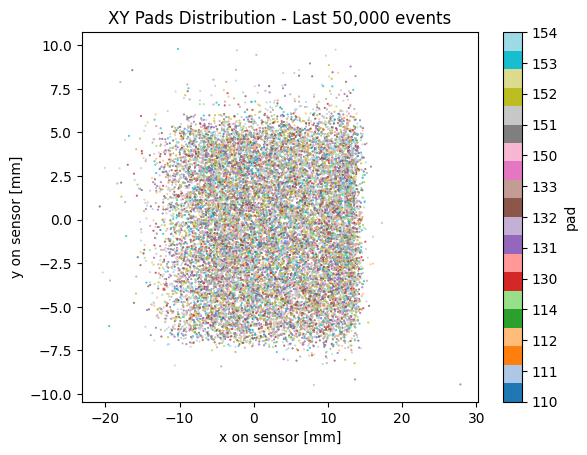

<Array [{hits: {...}, tele: {...}}, ..., {...}] type='17829 * {hits: {plane...'>

In [132]:
def pads_xy(data, central_pad):

    # determine the chosen pads
    base = list(range(central_pad - 2, central_pad + 3))
    pads = base + list(map(lambda x: x + 20, base)) + list(map(lambda x: x - 20, base))
    print(pads)

    # data from the first plane only
    first_plane_mask = data.hits.plane == 0
    first_plane_data = data.hits[first_plane_mask]
    
    # events with single hit in first plane
    single_hit_mask = ak.num(first_plane_data) == 1
    single_hit_first_plane_data = data[single_hit_mask] 

    # data from the first plane with single hit
    first_plane_single_hit = first_plane_data[single_hit_mask]

    # get events that starts at the chosen pads
    chosen_pads_mask = np.isin(first_plane_single_hit.ch, pads)
    chosen_pads_data = single_hit_first_plane_data[chosen_pads_mask]

    # chosen pads data
    chosen_pads = chosen_pads_data.hits.ch

    # get the xy data for each
    x = -chosen_pads_data.tele.x
    y = chosen_pads_data.tele.y
   
    # plot xy by color
    unique_pads = np.unique(chosen_pads)
    pad_to_idx = {p: i for i, p in enumerate(unique_pads)}
    color_idx = np.array([pad_to_idx[p] for p in chosen_pads])

    plt.scatter(x, y, c=color_idx, cmap='tab20', s=0.2)
    plt.colorbar(ticks=np.arange(len(unique_pads)),label='pad').set_ticklabels(unique_pads)
    plt.title("XY Pads Distribution - Last 50,000 events")
    plt.xlabel("x on sensor [mm]")
    plt.ylabel("y on sensor [mm]")
    plt.show()

    return chosen_pads_data

pads_xy(hit_data_scope_1081_filtered[-50000:], 132)
# pads_xy(hit_data_scope_1081_filtered[:50000], 132)

[130, 131, 132, 133, 134, 150, 151, 152, 153, 154, 110, 111, 112, 113, 114]


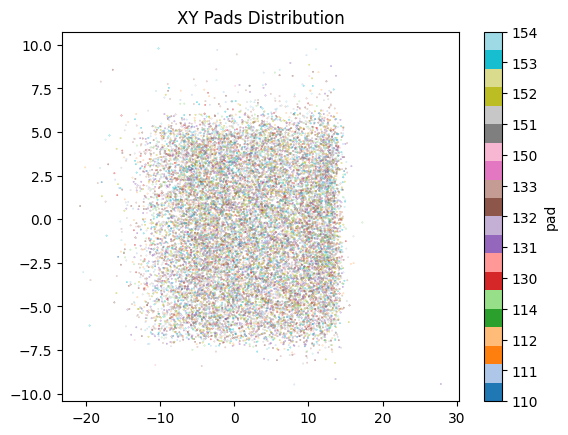

In [120]:
hit_data_scope_1081_filtered = sf.filter_chi2_scope_data(hit_data_scope_1081, 2) 
chosen_pads = sf.pads_xy(hit_data_scope_1081_filtered[-50000:], 132)
# chosen_pads = sf.pads_xy(hit_data_scope_1093, 125)